# Jupyter Notebook: vEMINR Official Tutorial: Training

### **1. Introduction**

Hello! Welcome to the interactive Jupyter Notebook tutorial for vEMINR.

vEMINR is a fast isotropic reconstruction method based on Implicit Neural Representations (INR), designed specifically for Volume Electron Microscopy (vEM) images. It aims to solve the problem where the axial resolution (Z-axis) of vEM images is significantly lower than the lateral resolution (XY-plane), thereby enabling high-quality 3D reconstruction. Compared to traditional and other deep learning methods, vEMINR shows significant advantages in both reconstruction speed and quality, making it particularly suitable for processing terabyte-scale datasets.

This tutorial will guide you through the following steps:
*   **Environment Setup**: Clone the repository and install all necessary dependencies.
*   **Data Preparation**: Download and prepare a sample dataset for training and testing.
*   **Model Training**: Train the vEMINR model using the provided scripts.


**Core Resources:**
*   **Official Repository**: [https://github.com/KysonYang001/vEMINR](https://github.com/KysonYang001/vEMINR)

### **2. Data Preparation**

As described in the paper, vEMINR was tested on several public datasets, including the **EPFL mitochondria dataset** and the **CREMI dataset**. In this tutorial, we will use the EPFL dataset as an example.

vEMINR uses a self-supervised learning strategy. It treats the high-resolution XY slices from the anisotropic volume as the "ground truth (HR)" and then simulates the downsampling process using average pooling to generate low-resolution (LR) training data.

**Steps:**
1.  Download the dataset from the [EPFL data source](https://www.epfl.ch/labs/cvlab/data/data-em/) (usually a sequence of `.tiff` images).
2.  Organize the dataset according to the structure required by the repository. Typically, there will be a `dataset` or `data` folder. We will assume the following structure:
    ```
    vEMINR/
    └── data/
        └── EPFL/
            ├── train/
            │   ├── image.tiff
            └── test/
                └── ...
    ```
### 2.1 Prepare the Demo Data




Text(0.5, 1.0, 'YZ Layer 24')

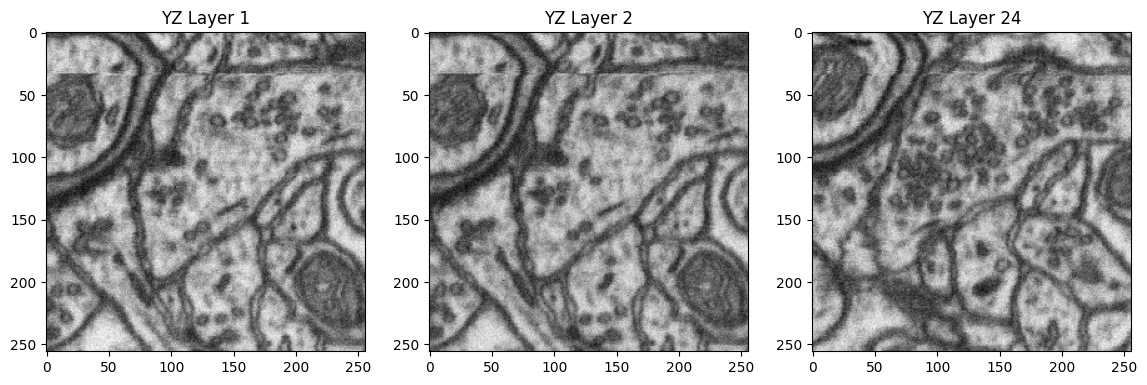

In [7]:
import matplotlib.pyplot as plt
from skimage import io

data_path = './data/fibsem_cropped_256.tif'
image = io.imread(data_path)
example_image_layer0 = image[:, 0, :]
example_image_layer1 = image[:, 1, :]
example_image_layer23 = image[:, 23, :]
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(example_image_layer0, cmap='gray')
plt.title('YZ Layer 1')
plt.subplot(1,3,2)
plt.imshow(example_image_layer1, cmap='gray')
plt.title('YZ Layer 2')
plt.subplot(1,3,3)
plt.imshow(example_image_layer23, cmap='gray')
plt.title('YZ Layer 24')

### **3. Model Training**

Now, we are ready to start training the model. The training process follows the workflow shown in Figure 1a of the paper.

The training script usually accepts several arguments, such as:
*   `--config`: training config.
*   `--save_path`: The path for save the results for this experiment.


In [8]:
import utils
import os
import argparse
import yaml
from models.controller import *

### 3.1 Train Degradation Model (Stage 1)

**Objective**: To train an "expert" model that understands how an image is degraded.

In this step, we use a self-supervised learning method (SimSiam) to train the model. The model learns to extract general degradation representations from pairs of images that have undergone different random degradations. This model does not perform super-resolution itself; its sole task is to understand "degradation."

For demonstration purposes, the model was trained for only 4 epochs. To train an effective degradation model, please utilize the train_degrade.py script and configure an appropriate number of epochs and a suitable batch size.

In [11]:
from train_degrade import Trainer as Degrade_trainer
args = argparse.Namespace()
args.config = 'configs/degradation.yaml'
args.savedir = 'checkpoints/degrade_test'
args.gpu = 0
args.tag = None
args.debug = False

with open(args.config, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    save_name = args.savedir
    if args.tag is not None:
        args.savedir = os.path.join(save_name, args.tag)
    if not os.path.exists(args.savedir):
        os.makedirs(args.savedir)
        print(f'Created save directory: {args.savedir}')

torch.manual_seed(config['seed'])

with open(os.path.join(args.savedir, 'config.yaml'), 'w') as f:
    yaml.dump(config, f, sort_keys=False)


trainer = Degrade_trainer(config, args)
timer = utils.Timer()
for epoch in range(1, config['epoch_max'] + 1):
    trainer.train(epoch, timer)

Using device: cuda:0
degrade dataset rank0: size=32
model: #params=1.6M


epoch 1/4, loss:0.0057, 0.2s 0.2s/0.6s
save in checkpoints/degrade_test/last.pth


save in checkpoints/degrade_test/best.pth


epoch 2/4, loss:-0.0504, 0.1s 0.4s/0.7s
save in checkpoints/degrade_test/last.pth
save in checkpoints/degrade_test/epoch_2.pth


save in checkpoints/degrade_test/best.pth


epoch 3/4, loss:-0.1581, 0.1s 0.5s/0.7s
save in checkpoints/degrade_test/last.pth
save in checkpoints/degrade_test/best.pth


epoch 4/4, loss:0.0118, 0.1s 0.7s/0.7s
save in checkpoints/degrade_test/last.pth
save in checkpoints/degrade_test/epoch_4.pth


### 3.2 Train Super-Resolution Model (Stage 2)

**Objective**: To train the main vEMINR model to perform the final super-resolution task.

**Key Step**: In this stage, we will load the main super-resolution model's architecture and **load the weights of the degradation model trained in Stage 1**. This allows the super-resolution model to leverage the "knowledge" learned by the degradation model to better guide the reconstruction process, significantly improving the results. The loss function here is the L1 loss between the reconstructed image and the original high-resolution image.

For demonstration purposes, the model was trained for only 5 epochs. To train an effective SR model, please utilize the train_INR.py script and configure an appropriate number of epochs and a suitable batch size.

In [10]:
from train_INR import Trainer as SR_trainer

args = argparse.Namespace()
args.config = 'configs/train_INR-rdn-liif-volume.yaml'
args.savedir = 'checkpoints/sr_test'
args.gpu = 0
args.tag = None
args.debug = False

#### read config file
with open(args.config, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    print('config loaded.')
    save_name = args.savedir
    if save_name is None:
        save_name = '_' + args.config.split('/')[-1][:-len('.yaml')]
    if os.path.exists(args.savedir) is False:
        os.makedirs(args.savedir)
        print('{} succeed'.format(args.savedir))
torch.manual_seed(config['seed'])

#### log file
with open(os.path.join(args.savedir, 'config.yaml'), 'w') as f:
    yaml.dump(config, f, sort_keys=False)

t = SR_trainer(config, args)
# train epochs
timer = utils.Timer()
for epoch in range(1, config['epoch_max'] + 1):
    t.train(epoch, timer)

config loaded.
train dataset rank0: size=32
val dataset rank0: size=32
model: #params=24.3M


epoch 1/5, loss:0.1681, val:16.4693 , 1.3s 1.3s/6.7s

save in checkpoints/sr_test/best.pth
save in checkpoints/sr_test/last.pth


epoch 2/5, loss:0.1081, val:18.2677 , 1.3s 4.2s/10.6s

save in checkpoints/sr_test/best.pth
save in checkpoints/sr_test/last.pth
save in checkpoints/sr_test/epoch-2.pth


epoch 3/5, loss:0.0839, val:17.2435 , 1.4s 7.6s/12.7s

save in checkpoints/sr_test/last.pth


epoch 4/5, loss:0.0724, val:21.0867 , 1.3s 10.0s/12.5s

save in checkpoints/sr_test/best.pth
save in checkpoints/sr_test/last.pth
save in checkpoints/sr_test/epoch-4.pth


epoch 5/5, loss:0.0648, val:23.9259 , 1.3s 13.5s/13.5s

save in checkpoints/sr_test/best.pth
save in checkpoints/sr_test/last.pth
